In [195]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, Phase, Roles
import random
import copy
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from learning_agents.actor_critic_model import ActorCriticAgent

# Identifying villager voting behavior patterns and stats

This notebook details the code used to look for certain identifiers in the voting patterns of villagers

## Behavioral Indicators and Stats

Other than training stats, possible in-game statistics may indicate different behavior and voting patterns amongst the agents

We want to 
 - Look at unique votes from villagers throughout accusation and voting. Do these go down?
    - Is there a difference between wins/losses?

 - When are wolves voted out? Earlier or later?
    - If so, when is the second wolf found? How many voting rounds after the first wolf killed



Here are some things we might care about finding out:
- [ ] How many execution votes led to ties? 
    - Did these favor the wolves or the villagers?
- [ ] Villagers who have the same votes as others between accusations (is there accord between villagers)
- [ ] What id's do wolves have in games with villager wins
- [ ] How many distinct votes do we have? (per accusation round, per voting round)


Some stuff might be specific to approval, plurality or ranked voting
Approval 
- [ ] How many villagers vote the exact same way (with approvals and neutrals )
- [ ] How many negative votes do villagers give on average. Does this change with training ? *Stat to track while training


In terms of gathering up the stats, does it make more sense to look at the history, or does it make sense to just gather them while we train? it might be better to do it post game?

## Setup for 

In [194]:
@torch.no_grad()
def play_recurrent_game_w_replays(env, wolf_policy, villager_agent, num_times=10, hidden_state_size=None, voting_type=None):
    wins = 0
    # loop = tqdm(range(num_times))
    game_replays = []

    for _ in range(num_times):
        ## Play the game 
        next_observations, _, _, _, _ = env.reset()
        # init recurrent stuff for actor and critic to 0 as well
        magent_obs = {agent: {'obs': [], 
                              # obs size, and 1,1,64 as we pass batch first
                              'hcxs': [(torch.zeros((1,1,hidden_state_size), dtype=torch.float32), torch.zeros((1,1,hidden_state_size), dtype=torch.float32))],
                    } for agent in env.agents if not env.agent_roles[agent]}

        wolf_action = None
        while env.agents:
            observations = copy.deepcopy(next_observations)
            actions = {}

            villagers = set(env.agents) & set(env.world_state["villagers"])
            wolves = set(env.agents) & set(env.world_state["werewolves"])

            # villagers actions
            for villager in villagers:
                #torch.tensor(env.convert_obs(observations['player_0']['observation']), dtype=torch.float)
                torch_obs = torch.tensor(env.convert_obs(observations[villager]['observation']), dtype=torch.float)
                obs = torch.unsqueeze(torch_obs, 0)

                # TODO: Testing this, we may need a better way to pass in villagers
                recurrent_cell = magent_obs[villager]["hcxs"][-1]
                
                # ensure that the obs is of size (batch,seq,inputs)
                policies, _, recurrent_cell = villager_agent(obs, recurrent_cell)
                _, game_action = villager_agent.get_action_from_policies(policies, voting_type=voting_type)

                if voting_type == "plurality":
                    actions[villager] = game_action.item()
                elif voting_type == "approval":
                    actions[villager] = game_action.tolist()

                #store the next recurrent cells
                magent_obs[villager]["hcxs"].append(recurrent_cell)

            phase = env.world_state['phase']
            for wolf in wolves:
                wolf_action = wolf_policy(env, wolf, action=wolf_action)
                actions[wolf] = wolf_action

            next_observations, _, _, _, _ = env.step(actions)

            # clear the wolf action if needed
            if env.world_state['phase'] == Phase.NIGHT:
                wolf_action = None
            
            if env.world_state['phase'] == Phase.ACCUSATION and phase == Phase.NIGHT:
                wolf_action = None
            
        ## Fill bigger buffer, keeping in mind sequence
        winner = env.world_state['winners']
        if winner == Roles.VILLAGER:
            wins += 1

        game_replays.append(copy.deepcopy(env.history))

        # loop.set_description(f"Villagers won {wins} out of a total of {num_times} games")
    
    return wins, game_replays

In [190]:
def random_coordinated_single_wolf(env, agent, action=None):
    villagers_remaining = set(env.world_state["villagers"]) & set(env.world_state['alive'])
    return action if action != None else int(random.choice(list(villagers_remaining)).split("_")[-1])

## Data collection

We are going to use a trained agent, an untrained agent, and a random agent.
This way we can maybe identify patterns that would seperate each one

In [191]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]
print(obs_size)
observations['player_0']['observation']

untrained_agent = ActorCriticAgent({"rec_hidden_size": 128, 
                                        "rec_layers": 1, 
                                        "hidden_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)

trained_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "hidden_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)
trained_agent.load_state_dict(torch.load("stored_agents/lstm_first_no_one_hot/plurality_agent_10_score_50"))

# random_agent = None

trained_wins, trained_replays = play_recurrent_game_w_replays(env, random_coordinated_single_wolf, trained_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")
untrained_wins, untrained_replays = play_recurrent_game_w_replays(env, random_coordinated_single_wolf, untrained_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")
# random_wins, random_replays = play_recurrent_game_w_replays(env, random_coordinated_single_wolf, random_agent, num_times=1000, hidden_state_size=128, voting_type="plurality")


33


In [192]:
trained_villager_wins = [r for r in trained_replays if r[-1]["winners"] == Roles.VILLAGER]
print(f'Trained villagers won {len(trained_villager_wins)} games')
untrained_villager_wins = [r for r in untrained_replays if r[-1]["winners"] == Roles.VILLAGER]
print(f'Untrained villagers won {len(untrained_villager_wins)} games')

316
48


The way the environment stores history is slightly different than observations. Whereas the latter stores the prior votes, env.history steps have the votes and the outcomes that occured at that particular day/phase/round.
This makes analysis slightly easier, but we still need to track a few things


In [193]:
# TODO: SANITY CHECK THAT NO VILLAGER WINS HAPPENED OTHER THAN AFTER THE VOTING ROUND

{<Phase.VOTING: 1>: 316}


In [205]:
print("Average amount of days until a win is achieved by villagers")
print(f'\t Trained villagers : {np.mean([villager_win[-1]["day"] for villager_win in trained_villager_wins]):2f}')
print(f'\t Untrained villagers : {np.mean([villager_win[-1]["day"] for villager_win in untrained_villager_wins]):2f}')

Average amount of days until a win is achieved by villagers
	 Trained villagers : 2.949367
	 Untrained villagers : 3.125000


We may want to increase the number of players to 15, keeping 2 werewolves, to see if the mean day stretches further

Lets look at unique votes accusation -> voting
How many unique votes are there from accusation to voting?
If they switch, does a bigger count switch down to a little one? or does a smaller count lose a number to the bigger one?

Did a villager switch to a werewolf vote?
wolf to wolf?

What proportion of votes are for werewolves?

How often is the vote against a dead player?

In situations where we have a wolf who died, do players still vote against them?

Do we have 3 way ties between both werewolves and the werewolf target?
Is it possible that we actually lose because there is less consensus between agents on who they want to target?

do villagers win more given a first wolf vote?
is there a vote they key on quicker?

On voting rounds:
    - Does a wolf get lucky, and agents split their votes between the wolves, and the wolf target actually gets killed?

General game questions:
    - Does the first target a wolf pick impact their chance of winning? Alternatively, do villagers key better on certain first wolf votes?
    - Do certain wolf id combinations lead to more villager wins? 



In [272]:
# first wolf kill
def when_did_wolves_get_killed(game):
    wolves = game[0]['werewolves']

    days_wolves_executed = []
    just_votes = []
    for step in game:
        if step["phase"] == Phase.VOTING:
            # first eecution
            if len(step["executed"]) == 1:
                if step['executed'][0] in wolves:
                    days_wolves_executed.append(step['day'])
            else:
                who_was_killed = list(set(step['executed']) - set(just_votes[-1]['executed']))[0]
                if who_was_killed  in wolves:
                    days_wolves_executed.append(step['day'])

            just_votes.append(step)
    
    if len(days_wolves_executed) < len(wolves):
        print("Not every wolf was killed!")
    
    return days_wolves_executed

wolf_execution_days = [when_did_wolves_get_killed(trained_villager_win) for trained_villager_win in trained_villager_wins]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'Days between wolf kills for trained agents : {np.mean(wolf_execution_duration_between):.3f}')

wolf_execution_days = [when_did_wolves_get_killed(untrained_villager_win) for untrained_villager_win in untrained_villager_wins]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'Days between wolf kills for untrained agents : {np.mean(wolf_execution_duration_between):.3f}')

Days between wolf kills for trained agents : 1.627
Days between wolf kills for untrained agents : 1.562


I wonder if this statistic would be different in a game with 15 villagers and 2 wolves...

In [276]:
wolves = trained_villager_wins[0][0]['werewolves']
print(f'Wolves : {wolves}\n')

just_votes = []
for step in trained_villager_wins[0]:
    if step["phase"] == Phase.NIGHT:
        continue
    if step["phase"] == Phase.VOTING:
        just_votes.append(step)

    villager_votes = [vote for player, vote in step['votes'].items() if player not in wolves]
    all_votes = list(step['votes'].values())

    unique_villager_votes = len(Counter(villager_votes))
    percent_of_villagers_targetting_wolves = sum([Counter(villager_votes)[int(wolf.split("_")[-1])] for wolf in wolves]) / float(len(villager_votes))

    # want to be careful, because on voting rounds, there is also the executed player in this set. so we need to remove them first
    if step["phase"] == Phase.VOTING:
        just_votes.append(step)
    
        if len(just_votes) == 1:
            percent_of_villagers_targetting_dead_players = 0 / float(len(villager_votes))
        else:
            percent_of_villagers_targetting_dead_players = sum([Counter(villager_votes)[dead_player] for dead_player in list((set(step['executed']) & set(just_votes[-2]['executed'])) | set(step['killed']))]) / float(len(villager_votes))
    else:
        percent_of_villagers_targetting_dead_players = sum([Counter(villager_votes)[dead_player] for dead_player in list(set(step['executed']) & set(step['killed']))]) / float(len(villager_votes))

    # percent_of_villagers_targetting_a_dead_wolf = None
    
    print(f'Day : {step["day"]} | Phase : {step["phase"]} | Round : {step["round"]}')
    print(f'Villager votes : {villager_votes}')
    print(f'\t | - {unique_villager_votes} players targetted, with {percent_of_villagers_targetting_wolves:.3f} of the votes targetting wolves')
    print(f'\t | - {percent_of_villagers_targetting_dead_players:.3f} share of the votes targetting dead players\n')


    #print(f'Villager counters : {Counter(villager_votes)}')

    #print(f'All votes : {all_votes}')
    #print(f'All votes counters : {Counter(all_votes)}')

Wolves : ['player_4', 'player_6']

Day : 1 | Phase : 0 | Round : 0
Villager votes : [10, 10, 10, 10, 10, 10, 10, 10]
	 | - 1 players targetted, with 0.000 of the votes targetting wolves
	 | - 0.000 share of the votes targetting dead players

Day : 1 | Phase : 0 | Round : 0
Villager votes : [5, 1, 9, 9, 4, 9, 9, 9]
	 | - 4 players targetted, with 0.125 of the votes targetting wolves
	 | - 0.000 share of the votes targetting dead players

Day : 1 | Phase : 0 | Round : 0
Villager votes : [9, 6, 6, 6, 5, 6, 9, 4]
	 | - 4 players targetted, with 0.625 of the votes targetting wolves
	 | - 0.000 share of the votes targetting dead players

Day : 1 | Phase : 0 | Round : 1
Villager votes : [3, 4, 6, 4, 9, 6, 4, 4]
	 | - 4 players targetted, with 0.750 of the votes targetting wolves
	 | - 0.000 share of the votes targetting dead players

Day : 1 | Phase : 1 | Round : 0
Villager votes : [6, 4, 8, 4, 4, 6, 4, 4]
	 | - 3 players targetted, with 0.875 of the votes targetting wolves
	 | - 0.000 share 

In [ ]:
villager_games

In [15]:
from collections import Counter
import matplotlib.pyplot as plt

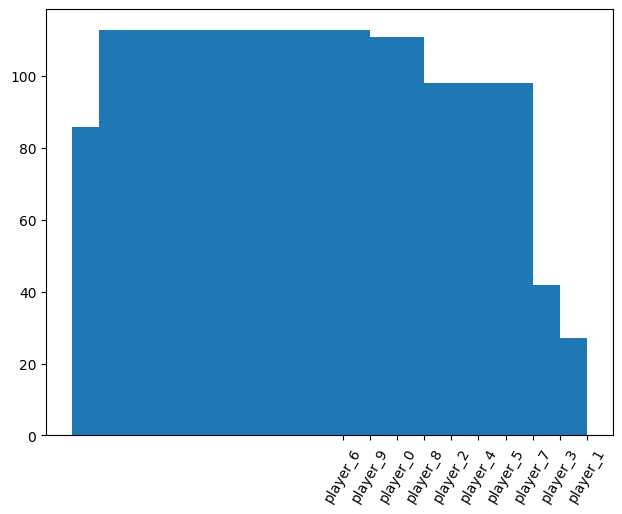

In [20]:
labels, values = zip(*Counter([item for sublist in [villager_win[-1]["werewolves"] for villager_win in untrained_villager_wins] for item in sublist]).items())
indexes = np.arange(len(labels))
width = 10

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.tight_layout()
plt.xticks(rotation=60)
plt.show()

In [ ]:
# load up trained agent
# load up fresh agent for comparisons

# play recurrent game_w_replays with both agents

# try to answer the questions below


# play_recurrent_game_w_replays()

In [ ]:
def collect_and_report_stats(env, information, ignore_wolf=True, mlflow_uri=None):
    total_self_votes = len([vals for player, vals in information.items() if vals["self_vote"] and (ignore_wolf and env.agent_roles[player] != Roles.WEREWOLF)])
    total_dead_votes = sum([vals["dead_vote"] for player, vals in information.items() if ignore_wolf and env.agent_roles[player] != Roles.WEREWOLF])
    total_viable_votes = sum([vals["viable_vote"] for player, vals in information.items() if ignore_wolf and env.agent_roles[player] != Roles.WEREWOLF])

    avg_self_votes = total_self_votes/len(information)
    avg_dead_votes = total_dead_votes/len(information)
    avg_viable_votes = total_viable_votes/len(information)

    return {
        "total_self_votes": total_self_votes,
        "total_dead_votes": total_dead_votes,
        "total_viable_votes": total_viable_votes,
        "avg_self_votes": avg_self_votes,
        "avg_dead_votes": avg_dead_votes,
        "avg_viable_votes": avg_viable_votes,
        "players_with_viable_votes": len([vals["viable_vote"] for player, vals in information.items() if ignore_wolf and env.agent_roles[player] != pare_Role.WEREWOLF])
    }

## Replay visualization

Need good ways to visualize the gameplay

In [ ]:
def print_replay(replay):
    #[wolf for wolf in stage["werewolves"]]
    #print("Werewolves \tVillagers")
    for stage in replay:
        wolf_votes = [(f'p_{wolf.split("_")[-1]}', stage["votes"][wolf]) for wolf in stage["werewolves"] if wolf in stage["votes"]]
        villager_votes = [(f'p{villager.split("_")[-1]}', stage["votes"][villager]) for villager in stage["villagers"] if villager in stage["votes"]]
        print(f'Wolves \t : {wolf_votes} \t\t Villagers : {villager_votes}')
        #print([f'{wolf.split("_")[-1]} : {stage["votes"]["player"_{wolf.split("_")[-1]}]}]' for wolf in stage["werewolves"]])
        # for wolf in stage['werewolves']:
        #     wid = wolf.split("_")[-1]
        #     pid = f"player_{wid}"
        #     stage["votes"][pid]
        #     print(f'p_{wid} : {stage["votes"][pid]}')
        # print(stage['votes'])

print_replay(replay[4])